# A demonstration of Python's power

Here's just a quick demonstration of how to accomplish a pretty interesting task, plotting a satellite image from a remote server, in Python. We won't explain much of what's going on here, but just want to show how much you can accomplish in Python.

First we just bring in some tools from a variety of Python libraries, using the `import` command. Python is really powerful at assembling various tools together like lego bricks.

In [1]:
# A whole bunch of imports
from urllib.request import urlopen

import matplotlib.pyplot as plt
from matplotlib import patheffects
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from metpy.io.gini import GiniFile
from metpy.plots.ctables import registry
from netCDF4 import num2date
from siphon.catalog import TDSCatalog

Now we download the latest water vapor satellite imagery from a remote server and pull out a variety of needed information. This makes use Unidata's MetPy and Siphon libraries.

In [2]:
# Scan the catalog and download the data
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/satellite/WV/EAST-CONUS_4km/current/catalog.xml')
dataset = cat.datasets[list(cat.datasets)[0]]
gini_ds = GiniFile(urlopen(dataset.access_urls['HTTPServer'])).to_dataset()

# Pull parts out of the data file
data_var = gini_ds.variables['WV']
x = gini_ds.variables['x'][:]
y = gini_ds.variables['y'][:]
time_var = gini_ds.variables['time']
proj_var = gini_ds.variables[data_var.grid_mapping]

# Set up the projection
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.earth_radius,
                   semiminor_axis=proj_var.earth_radius)

proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                             central_latitude=proj_var.latitude_of_projection_origin,
                             standard_parallels=[proj_var.standard_parallel],
                             globe=globe)

Now we plot the satellite data along with some mapping information; this plotting is provided by the matplotlib library, while the mapping capabilities come from a library called cartopy.

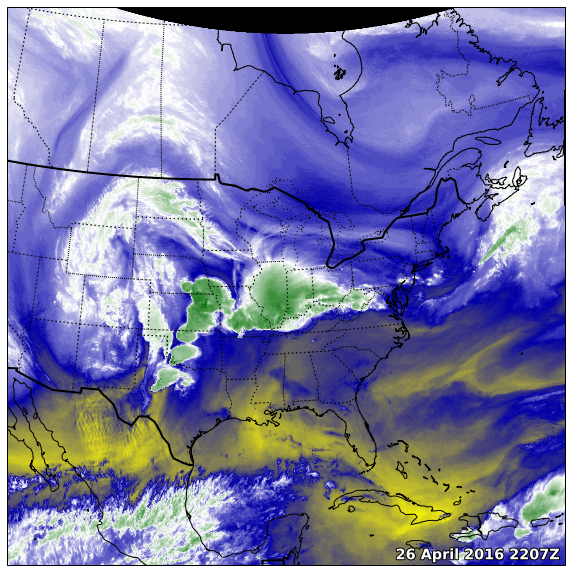

In [3]:
# Create the figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the image with our colormapping choices
wv_norm, wv_cmap = registry.get_with_steps('WVCIMSS', 0, 1)
im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
               cmap=wv_cmap, norm=wv_norm)

# Add mapping information
ax.coastlines(resolution='50m', color='black')
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes',
                                             scale='50m', facecolor='none')

ax.add_feature(state_boundaries, linestyle=':')
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Add the text, complete with outline
timestamp = num2date(time_var[:].squeeze(), time_var.units)
text = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')
text.set_path_effects([patheffects.Stroke(linewidth=2, foreground='black'),
                       patheffects.Normal()])